# Impact of 401(k) eligibility on net financial assets

In this case study, we will use real-world data from 401(k) analysis to explain how Causality library can be used to estimate average treatment effect (ATE) and conditional ATE (CATE).

## Background

In the early 1980s, the United States government introduced several tax deferred savings options for employees in an effort to increase individual saving for retirement. One popular option is the 401(k) plan, which allows employees to contribute a portion of their wages to individual accounts. The goal here is to understand the effect of 401(k) eligibility on net financial assets (which is a sum of 401(k) balances and non-401(k) assets) considering heterogeneity due to individual's characteristics (income in particular).

Since 401(k) plans are provided by employers, only employees of companies that offer those plans are eligible for participation. As such, we are dealing with a non-randomized study. Several factors (e.g. education, preference for saving) affect 401(k) eligibility as well as net financial assets.

## Data

We consider a sample from the Survey of Income and Program Participation in 1991. The sample consists of households where the reference individual is 25-64 years old, and at least one individual is employed but no one is self-employed. There are records of 9915 households in the sample. For each household, 44 variables are recorded that include the eligibility of the household reference person for the 401(k) plan (the treatment), net financial assets (the outcome), and other covariates, such as age, income, family size, education, marital status, etc. We consider 16 covariates in particular.

We summarise the variables used for this case study in the table below.

| Variable Name | Type | Details |
| --- | --- | --- |
|e401|Treatment|eligibility for the 401(k) plan|
|net_tfa|Outcome|net financial assets (in USD)|
|age|Covariate|Age|
|inc|Covariate|income (in USD)|
|fsize|Covariate|family size|
|educ|Covariate|education (in years)|
|male|Covariate|is a male?|
|db|Covariate|defined benefit pension|
|marr|Covariate|married?|
|twoearn|Covariate|two earners|
|pira|Covariate|participation in IRA|
|hown|Covariate|home owner?|
|hval|Covariate|home value (in USD)|
|hequity|Covariate|home equity (in USD)|
|hmort|Covariate|home mortgage (in USD)|
|nohs|Covariate|no high-school? (one-hot encoded)|
|hs|Covariate|high-school? (one-hot encoded)|
|smcol|Covariate|some-college? (one-hot encoded)|


The dataset is publicly available online from the [`hdm`](https://rdrr.io/cran/hdm/man/pension.html) R package. For more details about the data set, we refer the interested reader to the following paper:

V. Chernohukov, C. Hansen (2004). [The impact of 401(k) participation on the wealth distribution: An instrumental quantile regression analysis](http://www.mit.edu/~vchern/papers/ch_401k.pdf). The Review of Economic and Statistics 86 (3), 735–751. 

Let's load and analyse the data first.

In [1]:
import pandas as pd
df = pd.read_csv("pension.csv")

In [2]:
df.head()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Effect of 401(k) Eligibility on Net Financial Assets, Conditioned on Income

First we construct a causal graph of 401(k) plan eligibility (the treatment $T$), net financial assets (the outcome $Y$), control variables $W$ we adjust for assuming that they block all back-door paths between $Y$ and $T$, and income $X$ (the covariate of interest based on which we want to study the heterogeneity of treatment effect).

In [3]:
import networkx as nx
import dowhy.gcm as gcm

treatment_var = "e401"
outcome_var = "net_tfa"
covariates = ["age","inc","fsize","educ","male","db",
              "marr","twoearn","pira","hown","hval",
              "hequity","hmort","nohs","hs","smcol"]

edges = [(treatment_var, outcome_var)]
edges.extend([(covariate, treatment_var) for covariate in covariates])
edges.extend([(covariate, outcome_var) for covariate in covariates])

causal_graph = nx.DiGraph(edges)

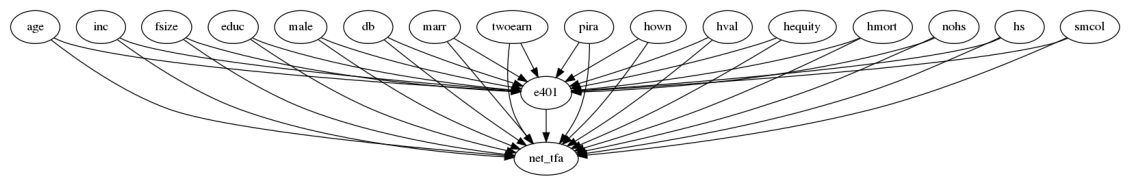

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 20] # Make plots larger

gcm.util.plot(causal_graph)

Here we created a simplified graph where there are no interactions between covariates (i.e. nodes in $X \cup W$). Most likely, that is not the case in practice. However, as we take joint samples of the covariates—directly from the observed data—later to estimate CATEs, we can ignore their interactions. 
 
Before we assign causal models to variables, let's plot their histograms to get an idea on the distribution of variables.

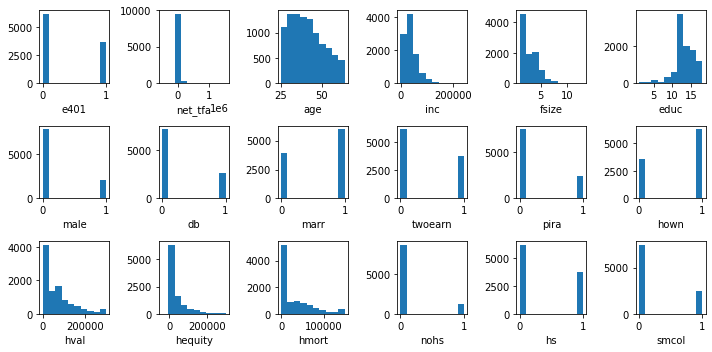

In [5]:
cols = [treatment_var, outcome_var]
cols.extend(covariates)
plt.figure(figsize=(10,5))
for i, col in enumerate(cols):
    plt.subplot(3,6,i+1)
    plt.grid(False)
    plt.hist(df[col])
    plt.xlabel(col)
plt.tight_layout()
plt.show()

We observe that real-valued variables do not follow well-known parameteric distributions like Gaussian. Therefore, we fit empirical distributions whenever those variables do not have parents, which is also suitable for categorical variables. 

Let's assign causal models to variables. For the treatment variable, we assign a classifier functional causal model (FCM) with a random forest classifier. For the outcome variable, we assign an additive noise model with a random forest regression as a function and empirical distribution for the noise. We assign empirical distributions to other variables as they do not have parents in the causal graph.

In [6]:
causal_model = gcm.StructuralCausalModel(causal_graph)
causal_model.set_causal_mechanism(treatment_var, gcm.ClassifierFCM(gcm.ml.create_random_forest_classifier()))
causal_model.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))
for covariate in covariates:
    causal_model.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

To fit a classifier FCM, we cast the treatment column to string type.

In [7]:
df = df.astype({treatment_var: str})

<div class="alert alert-block alert-info">
Instead of assigning the models manually, we can also automate this **if** we don't have prior knowledge or are not familiar with the statistical implications:
    
> gcm.auto.assign_causal_mechanisms(causal_model, df)
</div>

With that, we can now fit the learn the causal models from data.

In [8]:
gcm.fit(causal_model, df)

Fitting causal models:   0%|                                                                     | 0/18 [00:00<?, ?it/s]

Fitting causal mechanism of node e401:   0%|                                                     | 0/18 [00:00<?, ?it/s]

Fitting causal mechanism of node e401:   6%|██▌                                          | 1/18 [00:01<00:20,  1.23s/it]

Fitting causal mechanism of node net_tfa:   6%|██▎                                       | 1/18 [00:01<00:20,  1.23s/it]

Fitting causal mechanism of node net_tfa:  11%|████▋                                     | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node age:  11%|█████                                         | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node inc:  11%|█████                                         | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node fsize:  11%|████▉                                       | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node educ:  11%|█████                                        | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node male:  11%|█████                                        | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node db:  11%|█████▏                                         | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node marr:  11%|█████                                        | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node twoearn:  11%|████▋                                     | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node pira:  11%|█████                                        | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node hown:  11%|█████                                        | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node hval:  11%|█████                                        | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node hequity:  11%|████▋                                     | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node hmort:  11%|████▉                                       | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node nohs:  11%|█████                                        | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node hs:  11%|█████▏                                         | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node smcol:  11%|████▉                                       | 2/18 [00:06<00:58,  3.63s/it]

Fitting causal mechanism of node smcol: 100%|███████████████████████████████████████████| 18/18 [00:06<00:00,  2.74it/s]

Before computing CATE, we first divide households into equi-width bins of income percentiles. This allows us to study the impact on various income groups.

In [9]:
import numpy as np

percentages = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_edges = [0]
bin_edges.extend(np.quantile(df.inc, percentages[1:]).tolist())
bin_edges[-1] += 1 # adding 1 to the last edge as last edge is excluded by np.digitize

groups = [f'{percentages[i]*100:.0f}%-{percentages[i+1]*100:.0f}%' for i in range(len(percentages)-1)]
group_index_to_group_label = dict(zip(range(1, len(bin_edges)+1), groups))

Now we can compute CATE. To this end, we perform a randomised intervention on the treatment variable in the fitted causal graph, draw samples from the interventional distribution, group observations by the income group, and then compute the treatment effect in each group. 

In [10]:
np.random.seed(47)

def estimate_cate():
    samples = gcm.interventional_samples(causal_model, 
                                         {treatment_var: lambda x: np.random.choice(['0', '1'])},
                                         observed_data=df)
    eligible = samples[treatment_var] == '1'
    ate = samples[eligible][outcome_var].mean() - samples[~eligible][outcome_var].mean()
    result = dict(ate = ate)
    
    group_indices = np.digitize(samples['inc'], bin_edges)
    samples['group_index'] = group_indices
    
    for group_index in group_index_to_group_label:
        group_samples = samples[samples['group_index'] == group_index]
        eligible_in_group = group_samples[treatment_var] == '1'
        cate = group_samples[eligible_in_group][outcome_var].mean() - group_samples[~eligible_in_group][outcome_var].mean()
        result[group_index_to_group_label[group_index]] = cate
        
    return result

group_to_median, group_to_ci = gcm.confidence_intervals(estimate_cate, num_bootstrap_resamples=100)
print(group_to_median)
print(group_to_ci)

Estimating boostrap interval...:   0%|                                                          | 0/100 [00:00<?, ?it/s]

Estimating boostrap interval...:   1%|▌                                                 | 1/100 [00:00<01:00,  1.62it/s]

Estimating boostrap interval...:   2%|█                                                 | 2/100 [00:01<01:01,  1.61it/s]

Estimating boostrap interval...:   3%|█▌                                                | 3/100 [00:01<00:59,  1.64it/s]

Estimating boostrap interval...:   4%|██                                                | 4/100 [00:02<01:03,  1.52it/s]

Estimating boostrap interval...:   5%|██▌                                               | 5/100 [00:03<01:03,  1.50it/s]

Estimating boostrap interval...:   6%|███                                               | 6/100 [00:03<01:04,  1.46it/s]

Estimating boostrap interval...:   7%|███▌                                              | 7/100 [00:04<01:01,  1.51it/s]

Estimating boostrap interval...:   8%|████                                              | 8/100 [00:05<00:58,  1.57it/s]

Estimating boostrap interval...:   9%|████▌                                             | 9/100 [00:05<00:56,  1.61it/s]

Estimating boostrap interval...:  10%|████▉                                            | 10/100 [00:06<00:55,  1.64it/s]

Estimating boostrap interval...:  11%|█████▍                                           | 11/100 [00:06<00:53,  1.65it/s]

Estimating boostrap interval...:  12%|█████▉                                           | 12/100 [00:07<00:53,  1.66it/s]

Estimating boostrap interval...:  13%|██████▎                                          | 13/100 [00:08<00:52,  1.66it/s]

Estimating boostrap interval...:  14%|██████▊                                          | 14/100 [00:08<00:51,  1.67it/s]

Estimating boostrap interval...:  15%|███████▎                                         | 15/100 [00:09<00:51,  1.65it/s]

Estimating boostrap interval...:  16%|███████▊                                         | 16/100 [00:09<00:50,  1.66it/s]

Estimating boostrap interval...:  17%|████████▎                                        | 17/100 [00:10<00:49,  1.67it/s]

Estimating boostrap interval...:  18%|████████▊                                        | 18/100 [00:11<00:48,  1.68it/s]

Estimating boostrap interval...:  19%|█████████▎                                       | 19/100 [00:11<00:48,  1.68it/s]

Estimating boostrap interval...:  20%|█████████▊                                       | 20/100 [00:12<00:50,  1.60it/s]

Estimating boostrap interval...:  21%|██████████▎                                      | 21/100 [00:13<00:49,  1.60it/s]

Estimating boostrap interval...:  22%|██████████▊                                      | 22/100 [00:13<00:47,  1.63it/s]

Estimating boostrap interval...:  23%|███████████▎                                     | 23/100 [00:14<00:46,  1.65it/s]

Estimating boostrap interval...:  24%|███████████▊                                     | 24/100 [00:14<00:45,  1.66it/s]

Estimating boostrap interval...:  25%|████████████▎                                    | 25/100 [00:15<00:44,  1.67it/s]

Estimating boostrap interval...:  26%|████████████▋                                    | 26/100 [00:15<00:44,  1.68it/s]

Estimating boostrap interval...:  27%|█████████████▏                                   | 27/100 [00:16<00:43,  1.69it/s]

Estimating boostrap interval...:  28%|█████████████▋                                   | 28/100 [00:17<00:42,  1.69it/s]

Estimating boostrap interval...:  29%|██████████████▏                                  | 29/100 [00:17<00:42,  1.67it/s]

Estimating boostrap interval...:  30%|██████████████▋                                  | 30/100 [00:18<00:41,  1.68it/s]

Estimating boostrap interval...:  31%|███████████████▏                                 | 31/100 [00:18<00:40,  1.69it/s]

Estimating boostrap interval...:  32%|███████████████▋                                 | 32/100 [00:19<00:40,  1.69it/s]

Estimating boostrap interval...:  33%|████████████████▏                                | 33/100 [00:20<00:39,  1.69it/s]

Estimating boostrap interval...:  34%|████████████████▋                                | 34/100 [00:20<00:39,  1.69it/s]

Estimating boostrap interval...:  35%|█████████████████▏                               | 35/100 [00:21<00:38,  1.69it/s]

Estimating boostrap interval...:  36%|█████████████████▋                               | 36/100 [00:21<00:37,  1.69it/s]

Estimating boostrap interval...:  37%|██████████████████▏                              | 37/100 [00:22<00:37,  1.70it/s]

Estimating boostrap interval...:  38%|██████████████████▌                              | 38/100 [00:23<00:36,  1.69it/s]

Estimating boostrap interval...:  39%|███████████████████                              | 39/100 [00:23<00:35,  1.70it/s]

Estimating boostrap interval...:  40%|███████████████████▌                             | 40/100 [00:24<00:35,  1.69it/s]

Estimating boostrap interval...:  41%|████████████████████                             | 41/100 [00:24<00:35,  1.66it/s]

Estimating boostrap interval...:  42%|████████████████████▌                            | 42/100 [00:25<00:36,  1.60it/s]

Estimating boostrap interval...:  43%|█████████████████████                            | 43/100 [00:26<00:35,  1.60it/s]

Estimating boostrap interval...:  44%|█████████████████████▌                           | 44/100 [00:26<00:34,  1.60it/s]

Estimating boostrap interval...:  45%|██████████████████████                           | 45/100 [00:27<00:33,  1.63it/s]

Estimating boostrap interval...:  46%|██████████████████████▌                          | 46/100 [00:27<00:32,  1.65it/s]

Estimating boostrap interval...:  47%|███████████████████████                          | 47/100 [00:28<00:32,  1.65it/s]

Estimating boostrap interval...:  48%|███████████████████████▌                         | 48/100 [00:29<00:31,  1.66it/s]

Estimating boostrap interval...:  49%|████████████████████████                         | 49/100 [00:29<00:30,  1.68it/s]

Estimating boostrap interval...:  50%|████████████████████████▌                        | 50/100 [00:30<00:31,  1.61it/s]

Estimating boostrap interval...:  51%|████████████████████████▉                        | 51/100 [00:31<00:30,  1.63it/s]

Estimating boostrap interval...:  52%|█████████████████████████▍                       | 52/100 [00:31<00:29,  1.64it/s]

Estimating boostrap interval...:  53%|█████████████████████████▉                       | 53/100 [00:32<00:28,  1.65it/s]

Estimating boostrap interval...:  54%|██████████████████████████▍                      | 54/100 [00:32<00:27,  1.67it/s]

Estimating boostrap interval...:  55%|██████████████████████████▉                      | 55/100 [00:33<00:26,  1.67it/s]

Estimating boostrap interval...:  56%|███████████████████████████▍                     | 56/100 [00:34<00:26,  1.68it/s]

Estimating boostrap interval...:  57%|███████████████████████████▉                     | 57/100 [00:34<00:25,  1.69it/s]

Estimating boostrap interval...:  58%|████████████████████████████▍                    | 58/100 [00:35<00:24,  1.68it/s]

Estimating boostrap interval...:  59%|████████████████████████████▉                    | 59/100 [00:35<00:24,  1.66it/s]

Estimating boostrap interval...:  60%|█████████████████████████████▍                   | 60/100 [00:36<00:23,  1.67it/s]

Estimating boostrap interval...:  61%|█████████████████████████████▉                   | 61/100 [00:36<00:23,  1.68it/s]

Estimating boostrap interval...:  62%|██████████████████████████████▍                  | 62/100 [00:37<00:22,  1.68it/s]

Estimating boostrap interval...:  63%|██████████████████████████████▊                  | 63/100 [00:38<00:21,  1.69it/s]

Estimating boostrap interval...:  64%|███████████████████████████████▎                 | 64/100 [00:38<00:21,  1.69it/s]

Estimating boostrap interval...:  65%|███████████████████████████████▊                 | 65/100 [00:39<00:20,  1.70it/s]

Estimating boostrap interval...:  66%|████████████████████████████████▎                | 66/100 [00:39<00:20,  1.70it/s]

Estimating boostrap interval...:  67%|████████████████████████████████▊                | 67/100 [00:40<00:19,  1.69it/s]

Estimating boostrap interval...:  68%|█████████████████████████████████▎               | 68/100 [00:41<00:18,  1.69it/s]

Estimating boostrap interval...:  69%|█████████████████████████████████▊               | 69/100 [00:41<00:18,  1.69it/s]

Estimating boostrap interval...:  70%|██████████████████████████████████▎              | 70/100 [00:42<00:17,  1.69it/s]

Estimating boostrap interval...:  71%|██████████████████████████████████▊              | 71/100 [00:42<00:17,  1.69it/s]

Estimating boostrap interval...:  72%|███████████████████████████████████▎             | 72/100 [00:43<00:16,  1.69it/s]

Estimating boostrap interval...:  73%|███████████████████████████████████▊             | 73/100 [00:44<00:15,  1.69it/s]

Estimating boostrap interval...:  74%|████████████████████████████████████▎            | 74/100 [00:44<00:15,  1.69it/s]

Estimating boostrap interval...:  75%|████████████████████████████████████▊            | 75/100 [00:45<00:14,  1.69it/s]

Estimating boostrap interval...:  76%|█████████████████████████████████████▏           | 76/100 [00:45<00:14,  1.69it/s]

Estimating boostrap interval...:  77%|█████████████████████████████████████▋           | 77/100 [00:46<00:14,  1.62it/s]

Estimating boostrap interval...:  78%|██████████████████████████████████████▏          | 78/100 [00:47<00:13,  1.60it/s]

Estimating boostrap interval...:  79%|██████████████████████████████████████▋          | 79/100 [00:47<00:13,  1.60it/s]

Estimating boostrap interval...:  80%|███████████████████████████████████████▏         | 80/100 [00:48<00:12,  1.63it/s]

Estimating boostrap interval...:  81%|███████████████████████████████████████▋         | 81/100 [00:48<00:11,  1.65it/s]

Estimating boostrap interval...:  82%|████████████████████████████████████████▏        | 82/100 [00:49<00:10,  1.66it/s]

Estimating boostrap interval...:  83%|████████████████████████████████████████▋        | 83/100 [00:50<00:10,  1.66it/s]

Estimating boostrap interval...:  84%|█████████████████████████████████████████▏       | 84/100 [00:50<00:09,  1.67it/s]

Estimating boostrap interval...:  85%|█████████████████████████████████████████▋       | 85/100 [00:51<00:08,  1.68it/s]

Estimating boostrap interval...:  86%|██████████████████████████████████████████▏      | 86/100 [00:51<00:08,  1.67it/s]

Estimating boostrap interval...:  87%|██████████████████████████████████████████▋      | 87/100 [00:52<00:07,  1.68it/s]

Estimating boostrap interval...:  88%|███████████████████████████████████████████      | 88/100 [00:53<00:07,  1.69it/s]

Estimating boostrap interval...:  89%|███████████████████████████████████████████▌     | 89/100 [00:53<00:06,  1.69it/s]

Estimating boostrap interval...:  90%|████████████████████████████████████████████     | 90/100 [00:54<00:05,  1.70it/s]

Estimating boostrap interval...:  91%|████████████████████████████████████████████▌    | 91/100 [00:54<00:05,  1.70it/s]

Estimating boostrap interval...:  92%|█████████████████████████████████████████████    | 92/100 [00:55<00:04,  1.70it/s]

Estimating boostrap interval...:  93%|█████████████████████████████████████████████▌   | 93/100 [00:56<00:04,  1.70it/s]

Estimating boostrap interval...:  94%|██████████████████████████████████████████████   | 94/100 [00:56<00:03,  1.70it/s]

Estimating boostrap interval...:  95%|██████████████████████████████████████████████▌  | 95/100 [00:57<00:02,  1.70it/s]

Estimating boostrap interval...:  96%|███████████████████████████████████████████████  | 96/100 [00:57<00:02,  1.70it/s]

Estimating boostrap interval...:  97%|███████████████████████████████████████████████▌ | 97/100 [00:58<00:01,  1.69it/s]

Estimating boostrap interval...:  98%|████████████████████████████████████████████████ | 98/100 [00:59<00:01,  1.69it/s]

Estimating boostrap interval...:  99%|████████████████████████████████████████████████▌| 99/100 [00:59<00:00,  1.70it/s]

Estimating boostrap interval...: 100%|████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.70it/s]

Estimating boostrap interval...: 100%|████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]

{'ate': 6374.669975043572, '0%-20%': 3959.1640102133306, '20%-40%': 3248.610968832368, '40%-60%': 5783.670162029327, '60%-80%': 7400.505093357383, '80%-100%': 11319.874556152214}
{'ate': array([4853.54623284, 8182.23223352]), '0%-20%': array([2599.53318617, 5467.96527923]), '20%-40%': array([1312.37648583, 5506.26045581]), '40%-60%': array([3442.31330827, 8266.81945484]), '60%-80%': array([ 4703.93751523, 10337.64412052]), '80%-100%': array([ 4580.2861924 , 18369.08432759])}


The average treatment effect of 401(k) eligibility on net financial assets is positive as indicated by the confidence interval $[4902.24, 8486.89]$. Now, let's plot CATEs of various income groups to get a clear picture.

/tmp/ipykernel_5979/1344202636.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((x, x), (ci[0], ci[1]), 'ro-', color='orange')


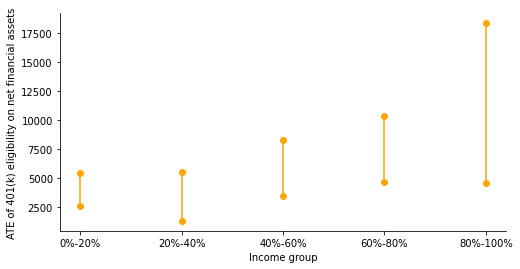

In [11]:
fig = plt.figure(figsize=(8,4))
for x, group in enumerate(groups):
    ci = group_to_ci[group]
    plt.plot((x, x), (ci[0], ci[1]), 'ro-', color='orange')
ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(len(groups)), groups)
plt.xlabel('Income group')
plt.ylabel('ATE of 401(k) eligibility on net financial assets')
plt.show()

The impact increases as one moves from lower to higher income groups. This result seems to be consistent with the resource constraints of the different income groups.